In [2]:
import numpy as np
from matplotlib import pyplot as plt
import skimage.transform as skimt
import time
import scipy.sparse as sp
import copy

import pyxu.operator as pyxop
import os
import src.tomo_fusion.tools.helpers as tomo_helps
import src.tomo_fusion.tools.plotting_fcts as tomo_plots
import src.tomo_fusion.bayesian_computations as bcomp
import src.tomo_fusion.functionals_definition as fct_def
import src.tomo_fusion.hyperparameter_tuning as hyper_tune

/home/dhamm/miniconda3/envs/bayes-plasma-tomo/lib/python3.12/site-packages/cupy/_environment.py:540: UserWarning: 
--------------------------------------------------------------------------------

  CuPy may not function correctly because multiple CuPy packages are installed
  in your environment:

    cupy-cuda11x, cupy-cuda12x

  Follow these steps to resolve this issue:

    1. For all packages listed above, run the following command to remove all
       existing CuPy installations:

         $ pip uninstall <package_name>

      If you previously installed CuPy via conda, also run the following:

         $ conda uninstall cupy

    2. Install the appropriate CuPy package.
       Refer to the Installation Guide for detailed instructions.

         https://docs.cupy.dev/en/stable/install.html

--------------------------------------------------------------------------------

  warnings.warn(f'''
/home/dhamm/miniconda3/envs/bayes-plasma-tomo/lib/python3.12/site-packages/pyxu/info/plug

In [3]:
%load_ext autoreload
%autoreload 2

In [8]:
import os
print(os.getcwd())

/home/dhamm/Documents/Repos/bayes-plasma-tomo/src/results/phantom_analysis/uq_study_results


In [10]:
# Load phantom data
psis = np.load('../../dataset_generation/sxr_samples/psis.npy')
sxr_samples = np.load('../../dataset_generation/sxr_samples/sxr_samples_with_background.npy')
alphas = np.load('../../dataset_generation/sxr_samples/alpha_random_values.npy')
trim_val = np.load('../../dataset_generation/sxr_samples/trimming_values.npy')
random_peak_vals = np.load('../../dataset_generation/sxr_samples/peak_values_gaussian_background.npy')

# Analyze phantoms

In [257]:
idx = 14
#294,300,360,400,407
recon_shape = (120, 40)

anis_data_idx = np.load('sigma005/anis_data_'+str(idx)+'.npy', allow_pickle=True).item()
uq_data_idx = np.load('sigma005/uq_data_'+str(idx)+'.npy', allow_pickle=True).item()
uq_data_idx = np.load('sigma01/uq_data_'+str(idx)+'.npy', allow_pickle=True).item()
uq_data_idx = np.load('sigma005005/uq_data_'+str(idx)+'.npy', allow_pickle=True).item()

ground_truth = sxr_samples[idx, :, :].squeeze()
psi = psis[idx, :, :]


f,g = fct_def.define_loglikelihood_and_logprior(ground_truth, psi, sigma_err=uq_data_idx["sigma_err"],
                                                reg_fct_type="anisotropic", alpha=uq_data_idx["alpha"], seed=idx)

mask_core = tomo_helps.define_core_mask(psi=psi, dim_shape=recon_shape, trim_values_x=trim_val[idx,:])
reg_param = uq_data_idx["reg_param"]

In [79]:
anis_data_idx["CV_full_random"][0,np.argmin(anis_data_idx["CV_full_random"][1,:])]

np.float64(0.021544346900318822)

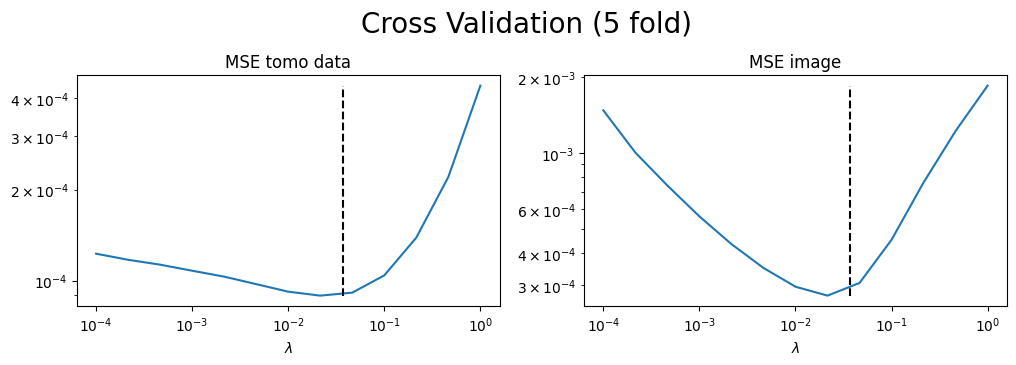

ValueError: Unknown key time

In [80]:
tomo_plots.plot_hyperparam_tuning_data(anis_data_idx, true_param_val=alphas[idx])

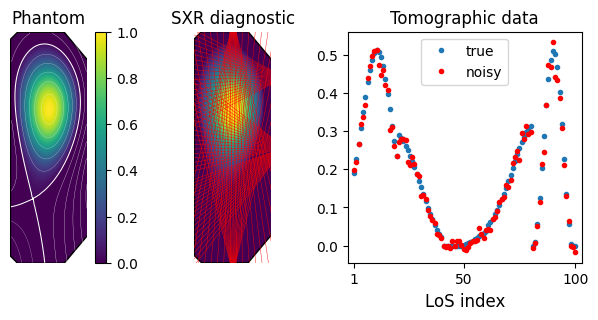

In [263]:
gt_plot = copy.deepcopy(ground_truth)
#gt_plot[ground_truth>0.99]=2
tomo_plots.plot_phantom_and_sxr_diag(ground_truth=gt_plot, psi=psi,
                                     tomo_data=uq_data_idx["tomo_data"],
                                     noisy_tomo_data=uq_data_idx["noisy_tomo_data"],
                                     tcv_plot_clip=True)

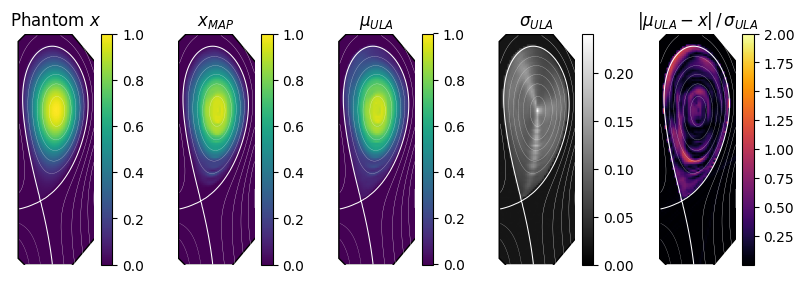

In [261]:
tomo_plots.plot_uq_data(uq_data=uq_data_idx, ground_truth=ground_truth, psi=psi, tcv_plot_clip=True,
                        plot_MAP=True, plot_mean=True, plot_std=True, plot_nb_stds=True,
                        cmaps=["viridis", "viridis", "viridis", "gray", "inferno"],
                        vmax_std=np.max(np.sqrt(uq_data_idx["var"])), vmax_nb_std=2)

In [258]:
gs=skimt.resize(ground_truth, uq_data_idx["im_MAP"].shape, anti_aliasing=False, mode='edge')

In [259]:
print(np.mean((gs-uq_data_idx["mean"])**2))

0.0006401785134541991


In [260]:
print(np.mean((gs-uq_data_idx["im_MAP"])**2))

0.000259939599464523


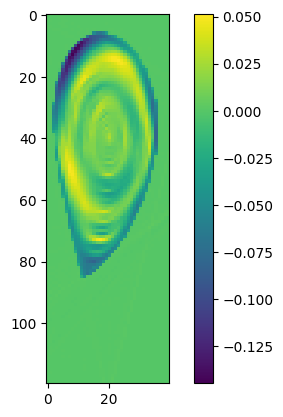

In [262]:
plt.imshow(uq_data_idx["im_MAP"]-uq_data_idx["mean"])
plt.colorbar()

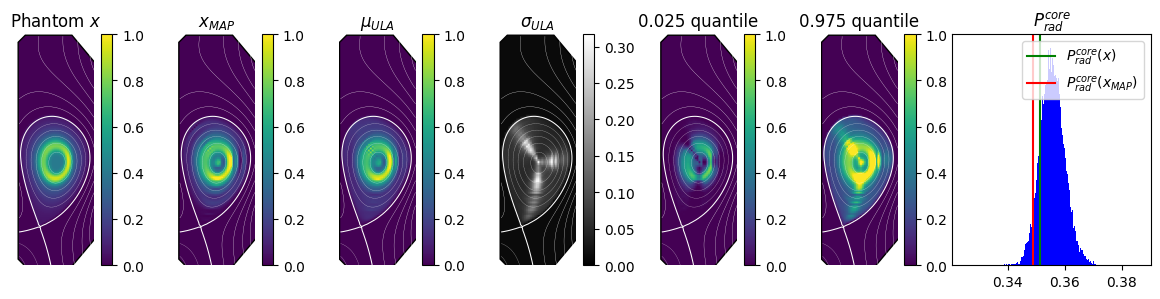

In [204]:
tomo_plots.plot_uq_data(uq_data=uq_data_idx, ground_truth=ground_truth, psi=psi, tcv_plot_clip=True,
                        plot_MAP=True, plot_mean=True, plot_std=True, plot_quantiles=True, plot_prad=True,
                        mask_core=mask_core,
                        cmaps=["viridis", "viridis", "viridis", "gray", "viridis", "viridis"], vmax_std=np.max(np.sqrt(uq_data_idx["var"])),
                        vmax_adjust_if_quantile=False)

Text(0.5, 1.0, 'Tomographic measurements: ULA predictions vs true measurements')

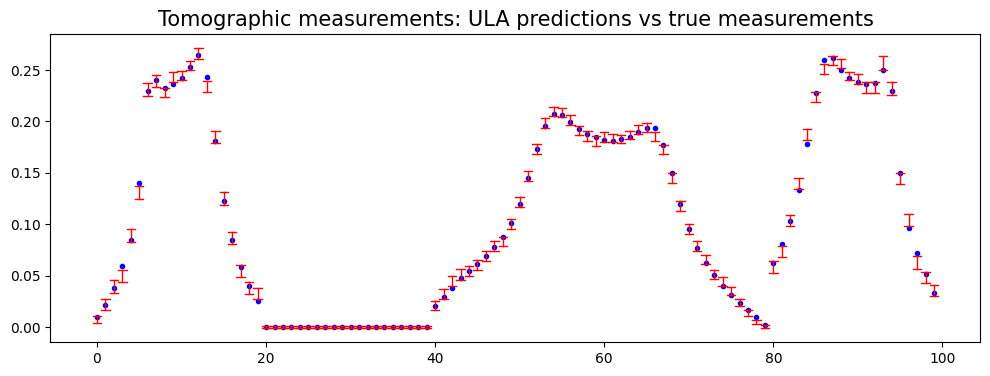

In [210]:
plt.figure(figsize=(12,4))
plt.plot(uq_data_idx["tomo_data"], 'b.')
for i in range(uq_data_idx["tomo_data"].size):
    tomo_plots.plot_errbar(i, uq_data_idx["mean_tomo_data"][i], np.sqrt(uq_data_idx["var_tomo_data"][i]),
                           left=0.5, right=0.5, linewidth=1)
plt.title("Tomographic measurements: ULA predictions vs true measurements", fontsize=15)

In [171]:
uq_data_idx["quantile_marks"]

[0.005, 0.025, 0.05, 0.25, 0.5, 0.75, 0.95, 0.975, 0.995]

In [172]:
gt_coarse = skimt.resize(ground_truth, uq_data_idx["im_MAP"].shape, anti_aliasing=False, mode='edge')
idxs =  np.where( (gt_coarse>=uq_data_idx["empirical_quantiles"][1,:,:]) & (gt_coarse<=uq_data_idx["empirical_quantiles"][-2,:,:]))
frac_pixels_within_quantiles = idxs[0].size / 4800
frac_pixels_within_quantiles_core = (idxs[0].size - (4800-np.sum(mask_core))) / np.sum(mask_core)
print("Percentage of pixels within 95% posterior quantiles (core) ", frac_pixels_within_quantiles_core)

Percentage of pixels within 95% posterior quantiles (core)  0.9663956639566396


In [173]:
gt_coarse = skimt.resize(ground_truth, uq_data_idx["im_MAP"].shape, anti_aliasing=False, mode='edge')
idxs =  np.where( (gt_coarse>=uq_data_idx["empirical_quantiles"][3,:,:]) & (gt_coarse<=uq_data_idx["empirical_quantiles"][-4,:,:]))
frac_pixels_within_quantiles = idxs[0].size / 4800
frac_pixels_within_quantiles_core = (idxs[0].size - (4800-np.sum(mask_core))) / np.sum(mask_core)
print("Percentage of pixels within 50% posterior quantiles (core) ", frac_pixels_within_quantiles_core)

Percentage of pixels within 50% posterior quantiles (core)  0.7956639566395663


In [250]:
print("Predicted emissivity peak location (mean +- std) ", uq_data_idx["mean_peak_loc"], "+-", np.sqrt(uq_data_idx["var_peak_loc"]))
print("True location of peak emissivity ", np.array(np.where(ground_truth==ground_truth.max())).reshape(2)/2)

Predicted emissivity peak location (mean +- std)  [55.75013 22.47978] +- [6.67062028 2.14275784]
True location of peak emissivity  [64.5 21. ]


# Compute statistics of pipeline performance on set of phantoms

In [185]:
pixels_within_quantiles = np.zeros((900, 4))
pixels_within_one_std = np.zeros(900)
#pixel_quantile_values = np.zeros((900,8,120,40))
pixels_within_two_stds = np.zeros(900)
pixels_within_three_stds = np.zeros(900)

peak_within_bounds = np.zeros((900,2))
peak_distance_from_mean = np.zeros((900,2))
value_of_ground_truth_at_estimated_peak = np.zeros(900)
#quantile_peak = ?
is_within_one_std = np.zeros(900)

prad_within_std = np.zeros(900)
prad_within_quantiles = np.zeros((900, 4))
prad_quantile_values = np.zeros((900,8))
prad_std_values = np.zeros(900)
prad_rel_error_mean = np.zeros(900)
prad_rel_error_map = np.zeros(900)

quantile_marks = [0.005, 0.025, 0.05, 0.25, 0.5, 0.75, 0.95, 0.975, 0.995]

for idx in range(900):
    recon_shape = (120, 40)

    anis_data_idx = np.load('sigma005/anis_data_'+str(idx)+'.npy', allow_pickle=True).item()
    uq_data_idx = np.load('sigma005/uq_data_'+str(idx)+'.npy', allow_pickle=True).item()

    ground_truth = sxr_samples[idx, :, :].squeeze()
    psi = psis[idx, :, :]


    f,g = fct_def.define_loglikelihood_and_logprior(ground_truth, psi, sigma_err=uq_data_idx["sigma_err"],
                                                    reg_fct_type="anisotropic", alpha=uq_data_idx["alpha"], seed=idx)

    mask_core = tomo_helps.define_core_mask(psi=psi, dim_shape=recon_shape, trim_values_x=trim_val[idx,:])
    reg_param = uq_data_idx["reg_param"]

    # compute pixels withing quantile bounds stats
    ground_truth_downsampled = skimt.resize(ground_truth, uq_data_idx["im_MAP"].shape, anti_aliasing=False, mode='edge') #* mask_core
    core_pixels_number = ground_truth_downsampled[ground_truth_downsampled>1e-3].size
    for j in range(4):
        idxs =  np.where( (ground_truth_downsampled>=uq_data_idx["empirical_quantiles"][j,:,:]) & (ground_truth_downsampled<=uq_data_idx["empirical_quantiles"][-(j+1),:,:]))
        frac_pixels_within_quantiles_core = (idxs[0].size - (4800-np.sum(mask_core))) / np.sum(mask_core)
        pixels_within_quantiles[idx, j] = frac_pixels_within_quantiles_core

    idxs_one_std = np.where( (ground_truth_downsampled>=(uq_data_idx["mean"]-np.sqrt(uq_data_idx["var"]))) &
                             (ground_truth_downsampled<=(uq_data_idx["mean"]+np.sqrt(uq_data_idx["var"]))))
    frac_pixels_within_one_std_core = (idxs_one_std[0].size - (4800-core_pixels_number)) / core_pixels_number
    #frac_pixels_within_one_std_core = (idxs_one_std[0].size - (4800-np.sum(mask_core))) / np.sum(mask_core)
    pixels_within_one_std[idx] = frac_pixels_within_one_std_core
    
    idxs_two_std = np.where( (ground_truth_downsampled>=(uq_data_idx["mean"]-2*np.sqrt(uq_data_idx["var"]))) &
                             (ground_truth_downsampled<=(uq_data_idx["mean"]+2*np.sqrt(uq_data_idx["var"]))))
    frac_pixels_within_two_stds_core = (idxs_two_std[0].size - (4800-core_pixels_number)) / core_pixels_number
    #frac_pixels_within_two_stds_core = (idxs_two_std[0].size - (4800-np.sum(mask_core))) / np.sum(mask_core)
    pixels_within_two_stds[idx] = frac_pixels_within_two_stds_core

    idxs_three_std = np.where( (ground_truth_downsampled>=(uq_data_idx["mean"]-3*np.sqrt(uq_data_idx["var"]))) &
                             (ground_truth_downsampled<=(uq_data_idx["mean"]+3*np.sqrt(uq_data_idx["var"]))))
    frac_pixels_within_three_stds_core = (idxs_three_std[0].size - (4800-core_pixels_number)) / core_pixels_number
    #frac_pixels_within_three_stds_core = (idxs_three_std[0].size - (4800-np.sum(mask_core))) / np.sum(mask_core)
    pixels_within_three_stds[idx] = frac_pixels_within_three_stds_core

        #pixel_quantile_values[idx, j] = np.quantile(uq_data_idx["empirical_quantiles"][j,:,:].flatten(), quantile_marks[j])
        #pixel_quantile_values[idx, j+4] = np.quantile(uq_data_idx["empirical_quantiles"][-(j+1),:,:].flatten(), quantile_marks[-(j+1)])

    # compute peak location stats
    true_peak_loc = np.array(np.where(ground_truth==ground_truth.max())).reshape(2)/2
    peak_within_bounds[idx, :] = (uq_data_idx["mean_peak_loc"] - true_peak_loc) / np.sqrt(uq_data_idx["var_peak_loc"])
    peak_distance_from_mean[idx, :] = (uq_data_idx["mean_peak_loc"] - true_peak_loc) * uq_data_idx["sampling"][0]
    value_of_ground_truth_at_estimated_peak[idx] = ground_truth_downsampled[int(uq_data_idx["mean_peak_loc"][0]), int(uq_data_idx["mean_peak_loc"][1])]
    is_within_one_std[idx] = ((np.abs(uq_data_idx["mean_peak_loc"][0] - true_peak_loc[0])< np.sqrt(uq_data_idx["var_peak_loc"][0]))
                              and (np.abs(uq_data_idx["mean_peak_loc"][1] - true_peak_loc[1])< np.sqrt(uq_data_idx["var_peak_loc"][1])))

    # compute prad stats
    # how many within credible ranges (quantiles), how many stds from mean is the true value (wrt mean), relative error stats on prad for both map and mean
    true_prad_core = tomo_helps.compute_radiated_power(ground_truth_downsampled, mask_core, uq_data_idx["sampling"])
    prad_within_std[idx] = (uq_data_idx["mean_prad_core"] - true_prad_core) / np.sqrt(uq_data_idx["var_prad_core"])
    prad_std_values[idx] = np.sqrt(uq_data_idx["var_prad_core"])

    for j in range(4):
        prad_within_quantiles[idx, j] = (
                                            (np.quantile(uq_data_idx["prads_core"], quantile_marks[-(j+1)]) > true_prad_core)
                                            and
                                            (np.quantile(uq_data_idx["prads_core"], quantile_marks[j]) < true_prad_core)
        )
        prad_quantile_values[idx, j] = np.quantile(uq_data_idx["prads_core"], quantile_marks[j])
        prad_quantile_values[idx, j+4] = np.quantile(uq_data_idx["prads_core"], quantile_marks[-(j+1)])

    prad_rel_error_mean[idx] = (uq_data_idx["mean_prad_core"] - true_prad_core) / true_prad_core
    prad_rel_error_map[idx] = (uq_data_idx["prad_map_core"] - true_prad_core) / true_prad_core

/tmp/ipykernel_62312/2993037175.py:78: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  prad_within_std[idx] = (uq_data_idx["mean_prad_core"] - true_prad_core) / np.sqrt(uq_data_idx["var_prad_core"])
/tmp/ipykernel_62312/2993037175.py:79: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  prad_std_values[idx] = np.sqrt(uq_data_idx["var_prad_core"])
/tmp/ipykernel_62312/2993037175.py:90: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  prad_rel_error_mean[idx] = (uq_data_idx["

In [1166]:
(mask_core*np.random.rand(120,40)).shape

(120, 40)

# Plot aggregate results

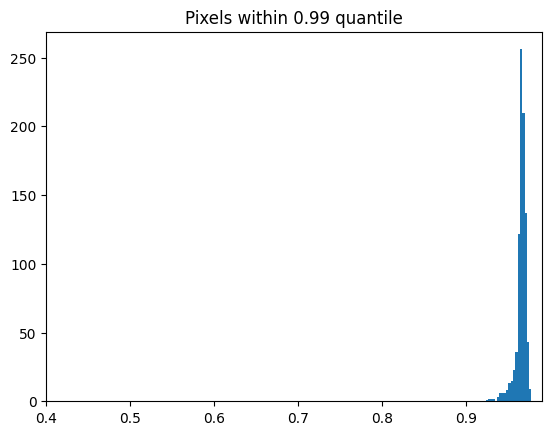

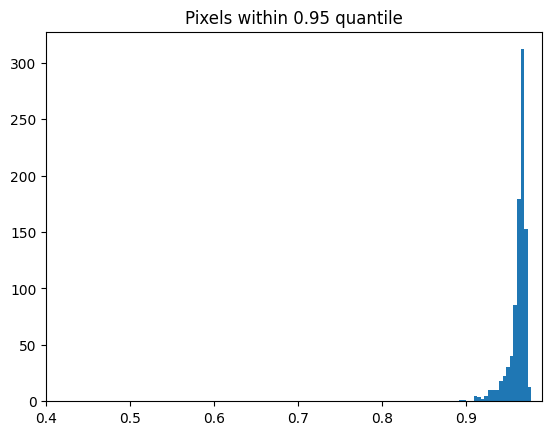

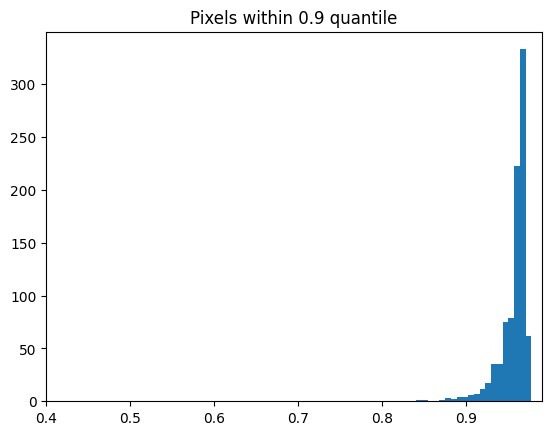

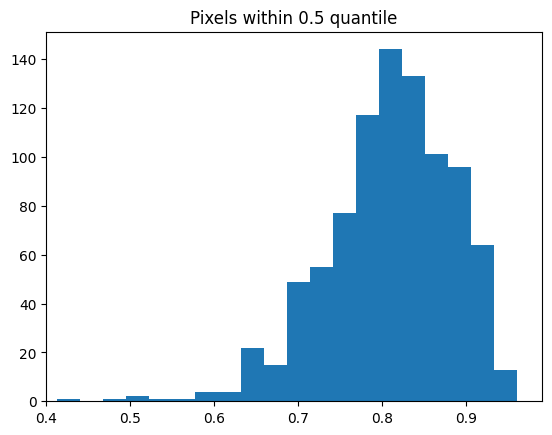

In [449]:
plt.hist(pixels_within_quantiles[:,0], bins=20)
plt.xlim([0.4,0.99])
plt.title("Pixels within 0.99 quantile")
plt.show()

plt.hist(pixels_within_quantiles[:,1], bins=20)
plt.xlim([0.4,0.99])
plt.title("Pixels within 0.95 quantile")
plt.show()

plt.hist(pixels_within_quantiles[:,2], bins=20)
plt.xlim([0.4,0.99])
plt.title("Pixels within 0.9 quantile")
plt.show()

plt.hist(pixels_within_quantiles[:,3], bins=20)
plt.xlim([0.4,0.99])
plt.title("Pixels within 0.5 quantile")
plt.show()

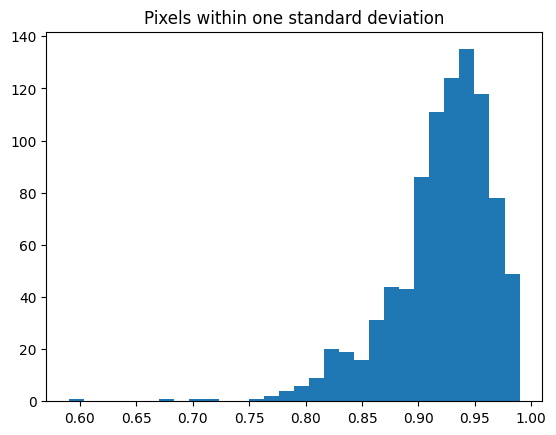

In [40]:
plt.hist(pixels_within_one_std, bins=30)
plt.title("Pixels within one standard deviation")
plt.show()

In [41]:
np.mean(pixels_within_one_std)

np.float64(0.9204286910286275)

In [42]:
np.mean(pixels_within_two_stds)

np.float64(0.9844574885460342)

# Study stats on estimation of peak position

In [604]:
from scipy.stats import pearsonr
corr_pearson = pearsonr(-peak_within_bounds[:,0], peak_within_bounds[:,1])
corr_pearson_abs = pearsonr(np.abs(peak_within_bounds[:,0]), np.abs(peak_within_bounds[:,1]))
corr_numpy = np.corrcoef(peak_within_bounds[:,0], peak_within_bounds[:,1])

In [605]:
corr_pearson

PearsonRResult(statistic=np.float64(0.35870326592367974), pvalue=np.float64(1.0225740140331118e-28))

In [556]:
corr_pearson_abs

PearsonRResult(statistic=np.float64(0.19867706679447056), pvalue=np.float64(1.831807255069829e-09))

In [607]:
corr_pearson_dist = pearsonr(-peak_distance_from_mean[:,0], peak_distance_from_mean[:,1])
corr_pearson_dist_abs = pearsonr(np.abs(peak_distance_from_mean[:,0]), np.abs(peak_distance_from_mean[:,1]))

In [609]:
print(corr_pearson_dist,"\n",corr_pearson_dist_abs)

PearsonRResult(statistic=np.float64(0.24953224742080776), pvalue=np.float64(3.053270857641151e-14)) 
 PearsonRResult(statistic=np.float64(0.4478876792589255), pvalue=np.float64(1.29535109775461e-45))


# Compute and plot line of sight density

In [819]:
f_mat = f.forward_model_linop.mat.toarray()
los_density = np.zeros(120,40)
for i in range(f_mat.shape[1]):
    f_mat_i = np.reshape(f_mat[:,i], (120,40))


numpy.ndarray

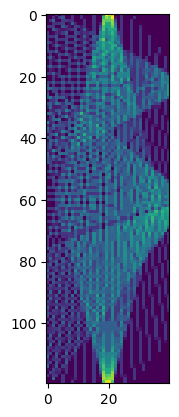

In [821]:
f_mat = f.forward_model_linop.mat.toarray()
plt.imshow(np.reshape(np.sum(f_mat,axis=0),(120,40)),cmap='viridis')

In [905]:
is_within_5cm = np.zeros(900)
for i in range(900):
    is_within_5cm[i] = np.abs(peak_distance_from_mean[i,0]<0.05) and np.abs(peak_distance_from_mean[i,1]<0.05)


In [907]:
np.sum(is_within_5cm)/900

np.float64(0.8544444444444445)

In [803]:
is_within_one_std.sum()/900

np.float64(0.6966666666666667)

# Investigate, for many phantoms, position of true peak and estimated one

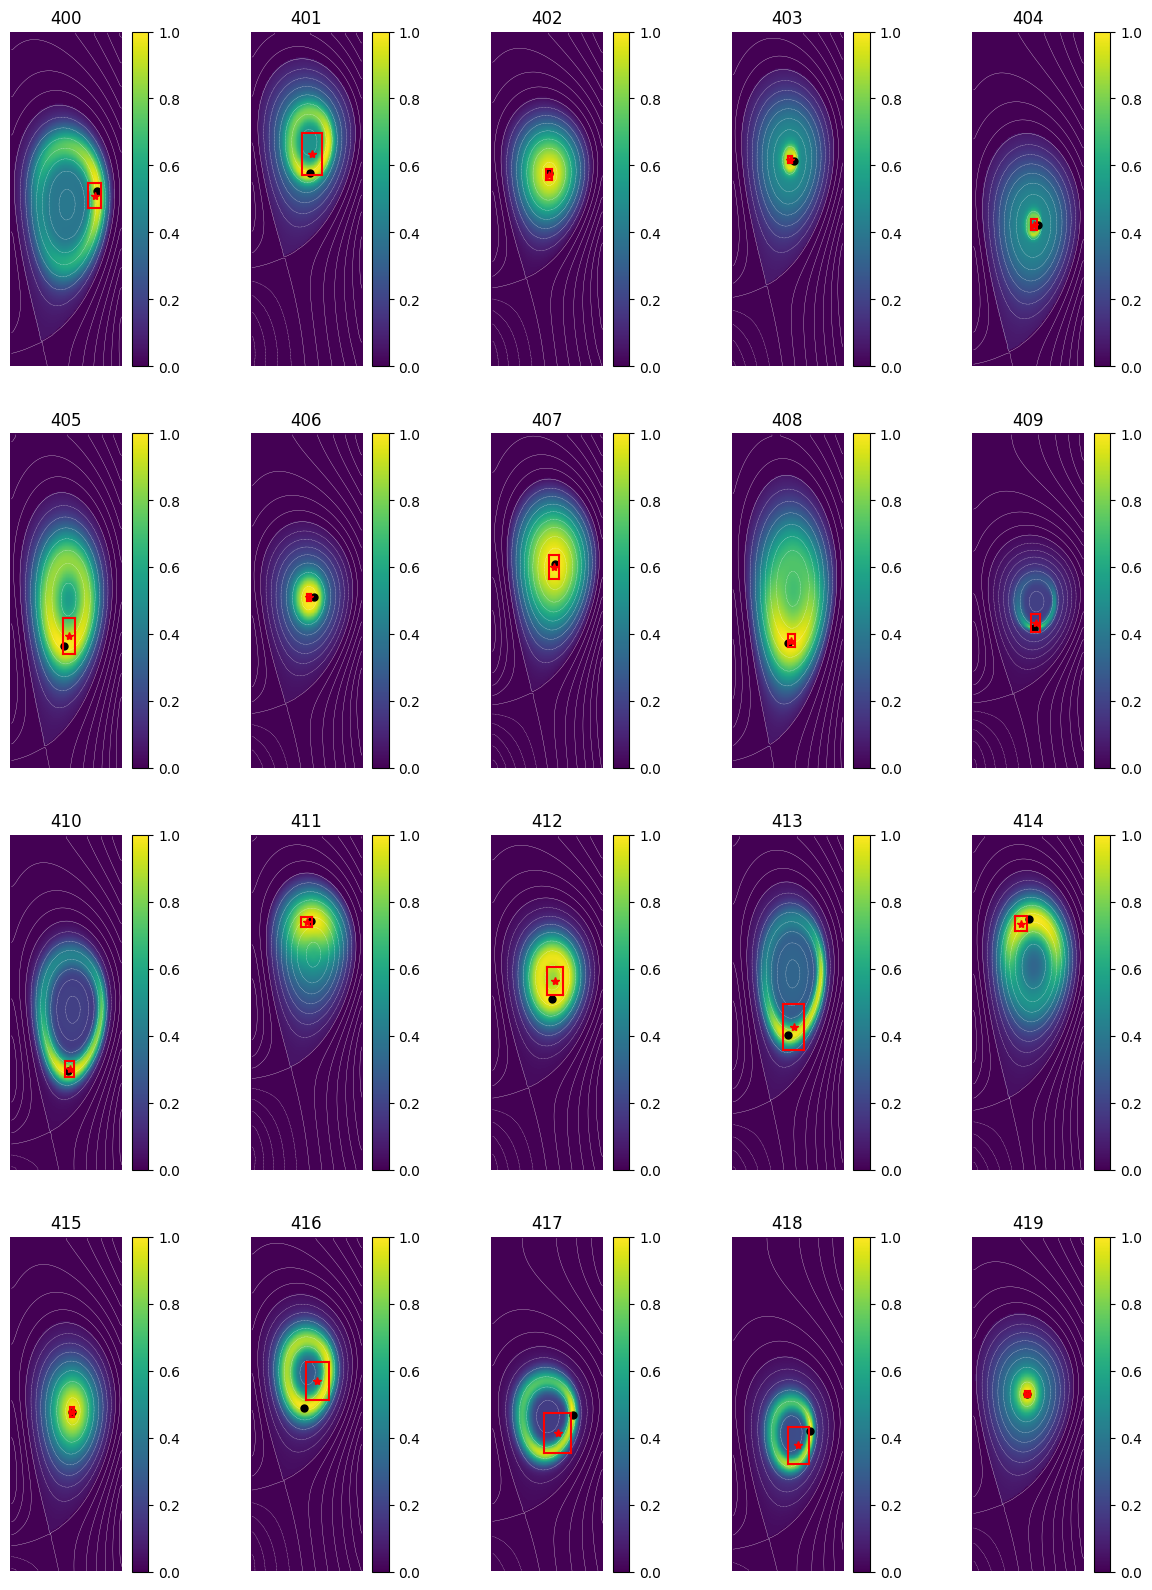

In [1139]:
block = 20
fig,ax=plt.subplots(4,5, figsize=(15,20))
for i in range(4):
    for j in range(5):
        ground_truth = sxr_samples[20*block + i*5+j, :, :].squeeze()
        im=ax[i,j].imshow(ground_truth)
        ax[i, j].contour(psis[20*block + i*5+j, :, :], origin="lower", levels=15, antialiased=True, colors="w", linewidths=0.2)

        # plot true peak
        peak_loc = np.array(np.where(ground_truth==ground_truth.max())).reshape(2)
        ax[i,j].plot(peak_loc[1],peak_loc[0],'k.', markersize=10)
        # plot position of estimated peak
        uq_data_idx = np.load('sigma005/uq_data_'+str(20*block + i*5+j)+'.npy', allow_pickle=True).item()
        estimated_peak_loc = uq_data_idx["mean_peak_loc"]
        ax[i,j].plot(2*estimated_peak_loc[1],2*estimated_peak_loc[0],'r*')
        lower_bound_hor, upper_bound_hor = (2*estimated_peak_loc[1]-2*np.sqrt(uq_data_idx["var_peak_loc"][1]),
                                            2*estimated_peak_loc[1]+2*np.sqrt(uq_data_idx["var_peak_loc"][1]))
        lower_bound_vert, upper_bound_vert = (2*estimated_peak_loc[0]-2*np.sqrt(uq_data_idx["var_peak_loc"][0]),
                                            2*estimated_peak_loc[0]+2*np.sqrt(uq_data_idx["var_peak_loc"][0]))
        ax[i,j].plot(np.array([lower_bound_hor,lower_bound_hor]),np.array([lower_bound_vert,upper_bound_vert]), 'r')
        ax[i,j].plot(np.array([upper_bound_hor,upper_bound_hor]),np.array([lower_bound_vert,upper_bound_vert]), 'r')
        ax[i,j].plot(np.array([lower_bound_hor,upper_bound_hor]),np.array([lower_bound_vert,lower_bound_vert]), 'r')
        ax[i,j].plot(np.array([lower_bound_hor,upper_bound_hor]),np.array([upper_bound_vert,upper_bound_vert]), 'r')

        plt.colorbar(im, ax=ax[i,j])
        ax[i,j].axis('off')
        ax[i,j].set_title("{}".format(20*block + i*5+j))
plt.show()

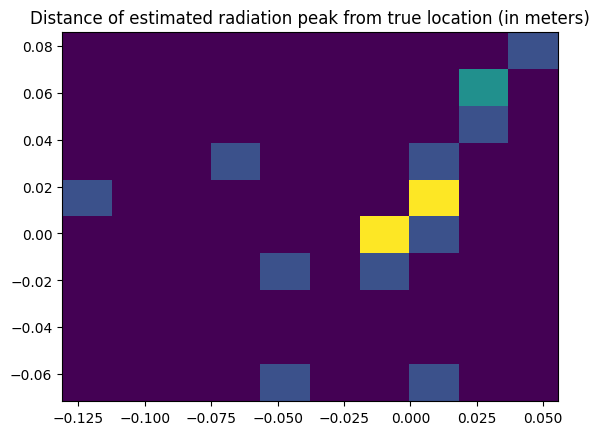

In [707]:
plt.hist2d(peak_distance_from_mean[20*block:20*(block+1),1], -peak_distance_from_mean[20*block:20*(block+1),0], bins=10, density=True)
plt.title("Distance of estimated radiation peak from true location (in meters)")
plt.show()

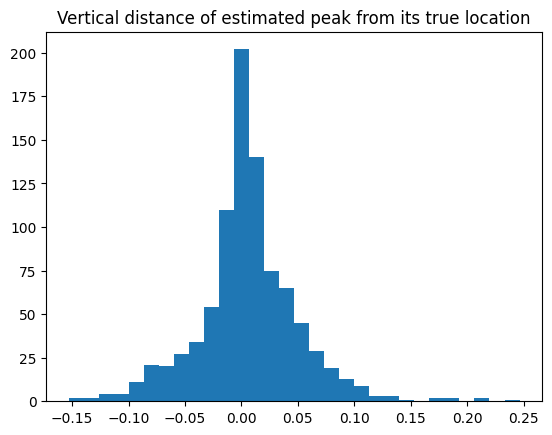

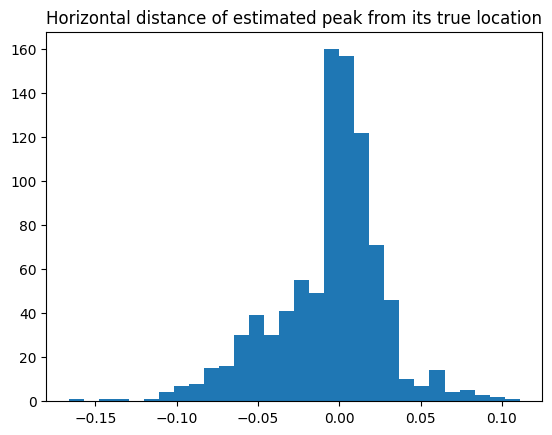

In [626]:
plt.hist(peak_distance_from_mean[:,0], bins=30)
plt.title("Vertical distance of estimated peak from its true location")
plt.show()
plt.hist(peak_distance_from_mean[:,1], bins=30)
plt.title("Horizontal distance of estimated peak from its true location")
plt.show()

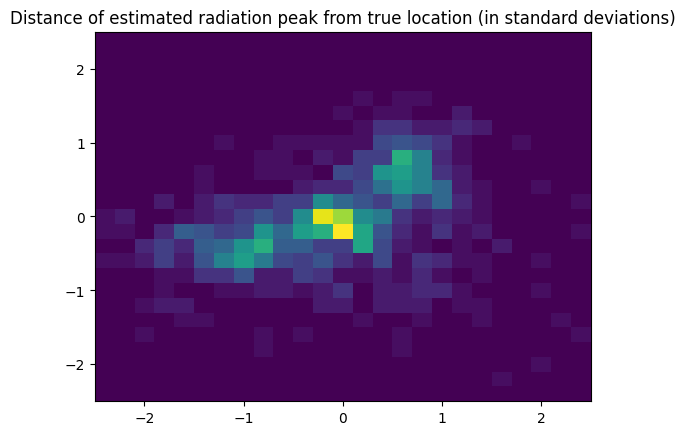

In [870]:
plt.hist2d(peak_within_bounds[:,1], -peak_within_bounds[:,0], bins=25, density=True, range=[[-2.5,2.5],[-2.5,2.5]])
plt.title("Distance of estimated radiation peak from true location (in standard deviations)")
plt.show()

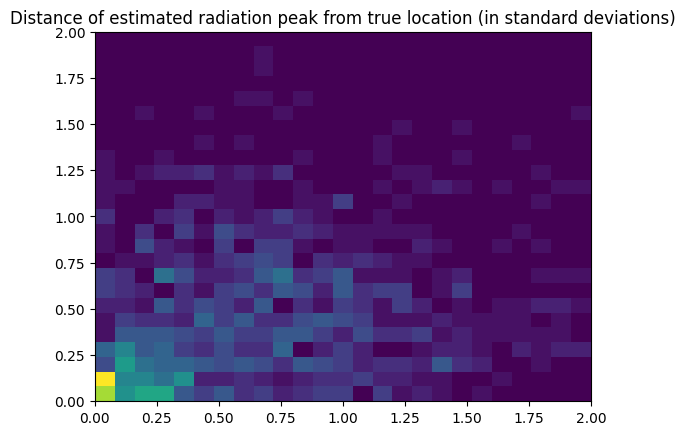

In [549]:
plt.hist2d(np.abs(peak_within_bounds[:,1]), np.abs(peak_within_bounds[:,0]), bins=25, density=True, range=[[0,2],[0,2]])
plt.title("Distance of estimated radiation peak from true location (in standard deviations)")
plt.show()

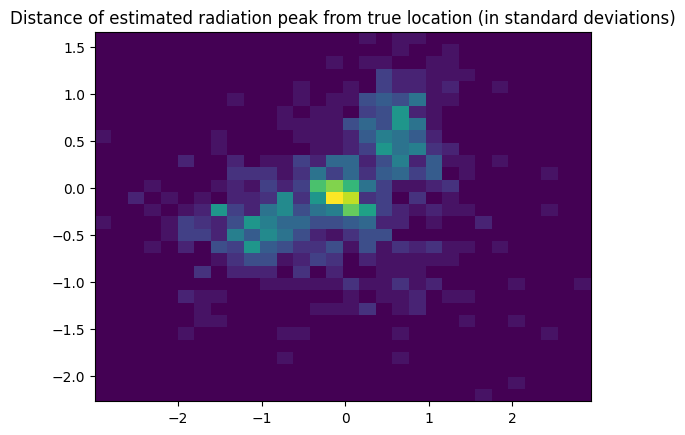

In [639]:
plt.hist2d(peak_within_bounds[:,1], -peak_within_bounds[:,0], bins=30, density=True)
plt.title("Distance of estimated radiation peak from true location (in standard deviations)")
plt.show()

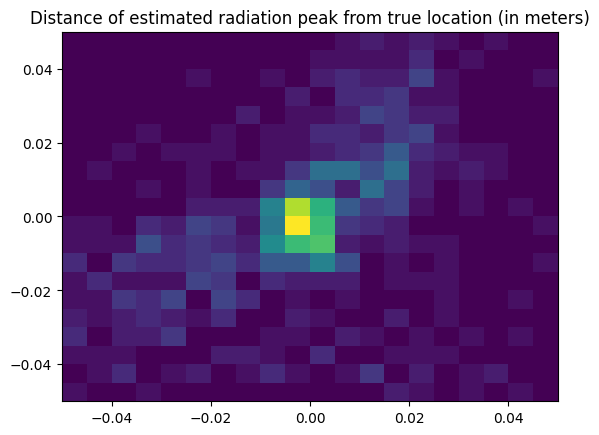

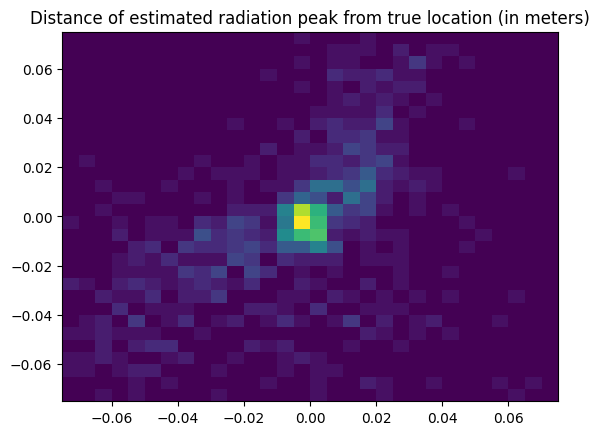

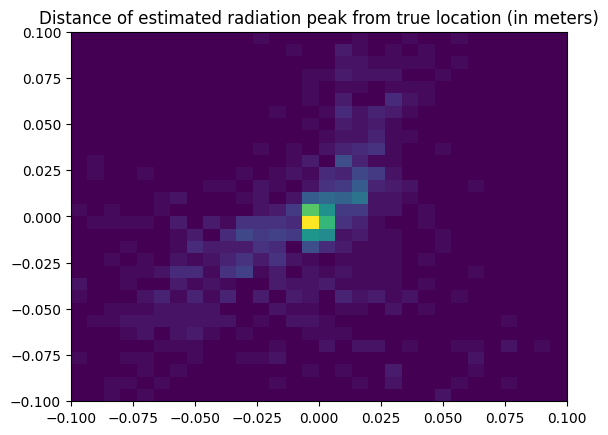

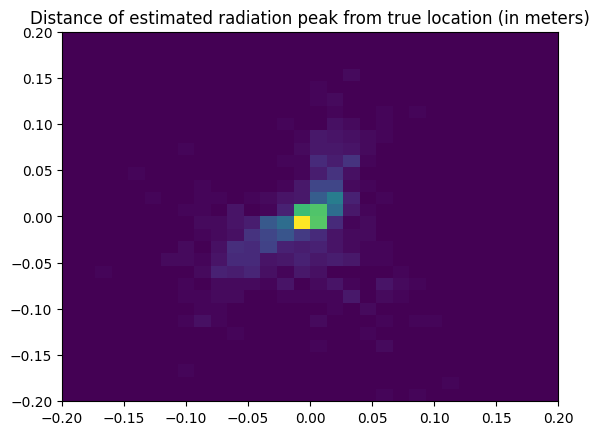

In [903]:
plt.hist2d(peak_distance_from_mean[:,1], -peak_distance_from_mean[:,0], bins=20, density=True, range=[[-0.05,0.05],[-0.05,0.05]])
plt.title("Distance of estimated radiation peak from true location (in meters)")
plt.show()

plt.hist2d(peak_distance_from_mean[:,1], -peak_distance_from_mean[:,0], bins=30, density=True, range=[[-0.075,0.075],[-0.075,0.075]])
plt.title("Distance of estimated radiation peak from true location (in meters)")
plt.show()

plt.hist2d(peak_distance_from_mean[:,1], -peak_distance_from_mean[:,0], bins=30, density=True, range=[[-0.1,0.1],[-0.1,0.1]])
plt.title("Distance of estimated radiation peak from true location (in meters)")
plt.show()

plt.hist2d(peak_distance_from_mean[:,1], -peak_distance_from_mean[:,0], bins=30, density=True, range=[[-0.2,0.2],[-0.2,0.2]])
plt.title("Distance of estimated radiation peak from true location (in meters)")
plt.show()

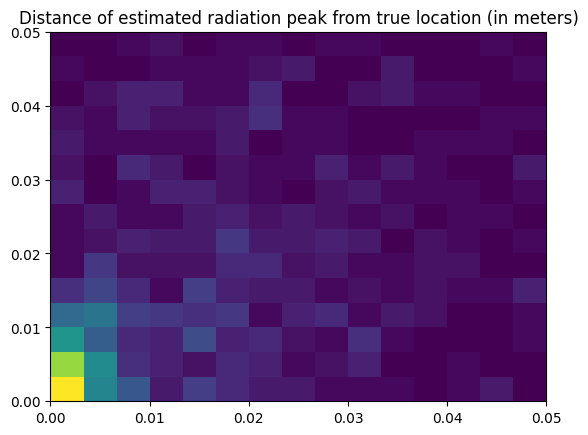

In [889]:
plt.hist2d(np.abs(peak_distance_from_mean[:,1]), np.abs(peak_distance_from_mean[:,0]), bins=15, density=True, range=[[0,0.05],[0,0.05]])
plt.title("Distance of estimated radiation peak from true location (in meters)")
plt.show()

In [461]:
np.argmin(peak_distance_from_mean[:,0])

np.int64(203)

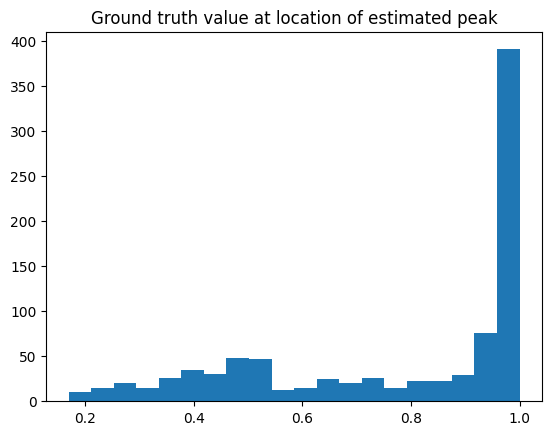

In [457]:
plt.hist(value_of_ground_truth_at_estimated_peak, bins=20)
plt.title("Ground truth value at location of estimated peak")
plt.show()

Text(0.5, 1.0, '$P_{rad}$: relative error of the mean $P_{rad}(\\mu_{ULA})$')

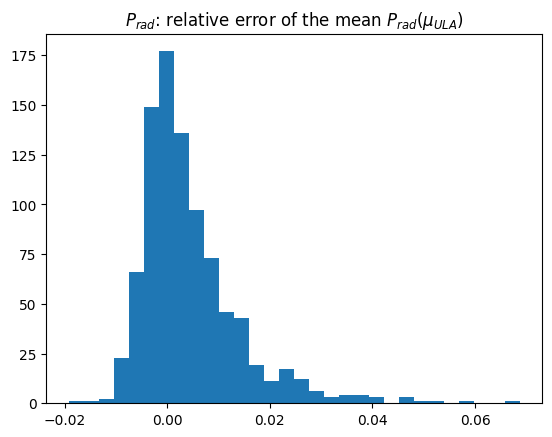

In [441]:
plt.hist(prad_rel_error_mean, bins=30)
plt.title(r"$P_{rad}$: relative error of the mean $P_{rad}(\mu_{ULA})$")

In [476]:
np.argmax(prad_rel_error_mean)

np.int64(99)

Text(0.5, 1.0, '$P_{rad}$: relative error of the MAP $P_{rad}(x_{MAP})$')

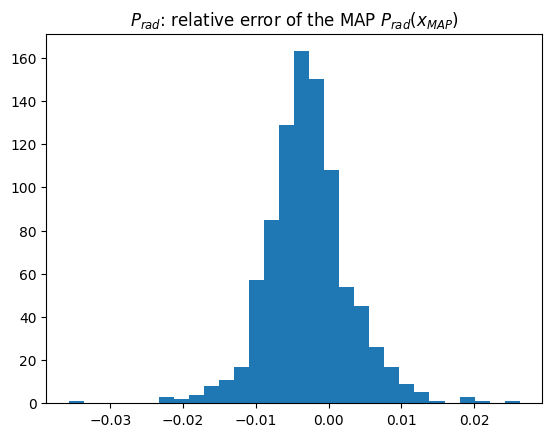

In [442]:
plt.hist(prad_rel_error_map, bins=30)
plt.title(r"$P_{rad}$: relative error of the MAP $P_{rad}(x_{MAP})$")

Text(0.5, 1.0, 'Distance of estimated radiated power from true one (in standard deviations)')

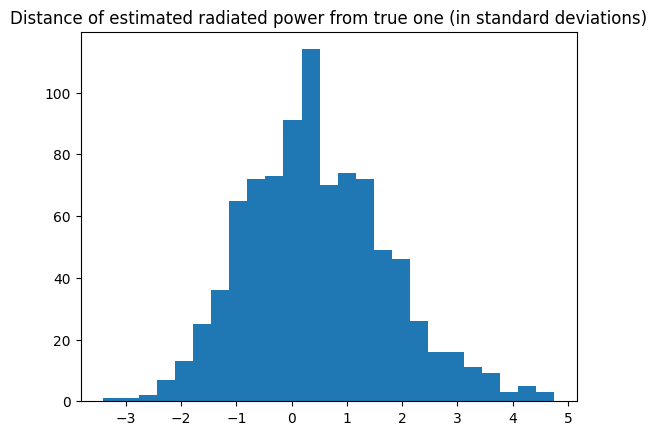

In [921]:
plt.hist(prad_within_std, bins=25)
plt.title("Distance of estimated radiated power from true one (in standard deviations)")

# Generate summary statistics

### Radiated power study

In [912]:
# prad
print(r"Relative error on Prad mean(ULA)", np.mean(prad_rel_error_mean), " +-", np.std(prad_rel_error_mean))
print(r"Relative error on Prad MAP", np.mean(prad_rel_error_map), " +-", np.std(prad_rel_error_map))

print()

Relative error on Prad mean(ULA) 0.004276600352743358  +- 0.009730830783753948
Relative error on Prad MAP -0.0028172879948247026  +- 0.005759411425580864



In [176]:
from scipy.stats import ttest_1samp
ttest_1samp(prad_rel_error_mean, popmean=0)
# there is a clear positive bias

TtestResult(statistic=np.float64(13.177365525023038), pvalue=np.float64(2.2042066332960118e-36), df=np.int64(899))

In [919]:
# prad, distance in terms of standard deviations from mean
print("Distance of true radiated power from mean value (in standard deviations)", np.mean(prad_within_std), " +- ", np.std(prad_within_std))

Distance of true radiated power from mean value (in standard deviations) 0.4678714429585913  +-  1.29625927985883


In [972]:
pearsonr(prad_within_std, random_peak_vals[:900])

# negative correlation between intensity of background and error on the radiated power: weaker background leads to larger overestimation of radiated power

PearsonRResult(statistic=np.float64(-0.3487920478858544), pvalue=np.float64(3.84276883733707e-27))

In [978]:
# percentage of samples where true prad is within one/two standard deviations

# coverage of credibility intervals

print("Percentage of phantoms such that true radiated power is within one standard deviation from mean", np.where(np.abs(prad_within_std)<1)[0].size/prad_within_std.size)
print("Percentage of phantoms such that true radiated power is within two standard deviations from mean ", np.where(np.abs(prad_within_std)<2)[0].size/prad_within_std.size)
print("Percentage of phantoms such that true radiated power is within three standard deviations from mean ", np.where(np.abs(prad_within_std)<3)[0].size/prad_within_std.size)

Percentage of phantoms such that true radiated power is within one standard deviation from mean 0.5611111111111111
Percentage of phantoms such that true radiated power is within two standard deviations from mean  0.8555555555555555
Percentage of phantoms such that true radiated power is within three standard deviations from mean  0.96


In [987]:
# quantiles

for j in range(4):
    print("Percentage of phantoms such that radiated power is within estimated {:.0f} % credibility interval ".format(100*(quantile_marks[-(j+1)]-quantile_marks[j])), 100*np.mean(prad_within_quantiles[:,j]), "%")

Percentage of phantoms such that radiated power is within estimated 99 % credibility interval  93.0 %
Percentage of phantoms such that radiated power is within estimated 95 % credibility interval  84.66666666666667 %
Percentage of phantoms such that radiated power is within estimated 90 % credibility interval  78.44444444444446 %
Percentage of phantoms such that radiated power is within estimated 50 % credibility interval  39.44444444444444 %


In [993]:
# compare width of quantile intervals with width of standard deviations (we need to store both)

for j in range(4):
    print("Width of {:.0f} % credibility interval ".format(100*(quantile_marks[-(j+1)]-quantile_marks[j])),
          np.mean((prad_quantile_values[:,j+4]-prad_quantile_values[:,j])), " +- ", np.std((prad_quantile_values[:,j+4]-prad_quantile_values[:,j])))
print("Width of twice the standard deviations ",
          np.mean(2*prad_std_values), " +- ", np.std(2*prad_std_values))

Width of 99 % credibility interval  0.014068059871594112  +-  0.0023350365464662247
Width of 95 % credibility interval  0.010716665867302152  +-  0.0017506444520067794
Width of 90 % credibility interval  0.008991247763236364  +-  0.0014457218890755491
Width of 50 % credibility interval  0.003682420932584339  +-  0.00056297378216174
Width of twice the standard deviations  0.005464358621775934  +-  0.0008720653915951023


In [994]:
for j in range(4):
    print("Ratio between width of {:.0f} % credibility interval and twice the standard deviation ".format(100*(quantile_marks[-(j+1)]-quantile_marks[j])),
         np.mean((prad_quantile_values[:,j+4]-prad_quantile_values[:,j])/(2*prad_std_values)), " +- ", np.std((prad_quantile_values[:,j+4]-prad_quantile_values[:,j])/(2*prad_std_values)))

Ratio between width of 99 % credibility interval and twice the standard deviation  2.5724801727233757  +-  0.047878774088974466
Ratio between width of 95 % credibility interval and twice the standard deviation  1.9600861581352795  +-  0.016577782569955957
Ratio between width of 90 % credibility interval and twice the standard deviation  1.645127887481104  +-  0.008492404941967168
Ratio between width of 50 % credibility interval and twice the standard deviation  0.6746673224734592  +-  0.011005616369936584


In [973]:
# small_random_peak_value = np.where(random_peak_vals[:900] < 0.4)
#
# indices_large_gaussian_peak = np.delete(np.arange(0,900), small_random_peak_value[0])
#
# pearsonr(prad_within_std[indices_large_gaussian_peak], random_peak_vals[indices_large_gaussian_peak])
#
# plt.hist(prad_within_std[indices_large_gaussian_peak], bins=25)
# plt.title("Distance of estimated radiated power from true one (in standard deviations)")

### Peak location study

In [1018]:
# Distance of true peak from estimated one

print("Distance of true peak from estimated one {:.2f}".format(100*np.mean(np.linalg.norm(peak_distance_from_mean, axis=1))), "cm +- {:.2f}".format(np.std(100*np.linalg.norm(peak_distance_from_mean, axis=1))), "cm")

print("Horizontal distance of true peak from estimated one {:.2f}".format(100*np.mean(peak_distance_from_mean[:,1])), "cm +- {:.2f}".format(100*np.std(peak_distance_from_mean[:,1])), "cm")

print("Vertical distance of true peak from estimated one {:.2f}".format(100*np.mean(-peak_distance_from_mean[:,0])), "cm +- {:.2f}".format(100*np.std(-peak_distance_from_mean[:,0])), "cm")

Distance of true peak from estimated one 4.32 cm +- 3.74 cm
Horizontal distance of true peak from estimated one -0.59 cm +- 3.40 cm
Vertical distance of true peak from estimated one -0.65 cm +- 4.51 cm


In [1019]:
print("Distance of true peak from estimated one {:.2f}".format(100*np.mean(np.linalg.norm(peak_distance_from_mean, axis=1))), "cm +- {:.2f}".format(np.std(100*np.linalg.norm(peak_distance_from_mean, axis=1))), "cm")

print("Horizontal distance of true peak from estimated one {:.2f}".format(100*np.mean(np.abs(peak_distance_from_mean[:,1]))), "cm +- {:.2f}".format(100*np.std(np.abs(peak_distance_from_mean[:,1]))), "cm")

print("Vertical distance of true peak from estimated one {:.2f}".format(100*np.mean(np.abs(peak_distance_from_mean[:,0]))), "cm +- {:.2f}".format(100*np.std(np.abs(peak_distance_from_mean[:,0]))), "cm")

Distance of true peak from estimated one 4.32 cm +- 3.74 cm
Horizontal distance of true peak from estimated one 2.43 cm +- 2.45 cm
Vertical distance of true peak from estimated one 3.15 cm +- 3.30 cm


In [1013]:
# plt.hist(peak_distance_from_mean[:,0], bins=25)
# plt.show()
# plt.hist(peak_distance_from_mean[:,1], bins=25)
# plt.show()
# plt.hist(np.linalg.norm(peak_distance_from_mean,axis=1), bins=25)
# plt.show()

In [1024]:
# Distance of true peak from estimated one (in standard deviations)

print("Horizontal distance (in standard deviations) of true peak from estimated one {:.2f}".format(np.mean(peak_within_bounds[:,1])), " +- {:.2f}".format(np.std(peak_within_bounds[:,1])))

print("Vertical distance (in standard deviations) of true peak from estimated one {:.2f}".format(np.mean(-peak_within_bounds[:,0])), " +- {:.2f}".format(np.std(-peak_within_bounds[:,0])))

Horizontal distance (in standard deviations) of true peak from estimated one -0.10  +- 0.86
Vertical distance (in standard deviations) of true peak from estimated one -0.06  +- 0.59


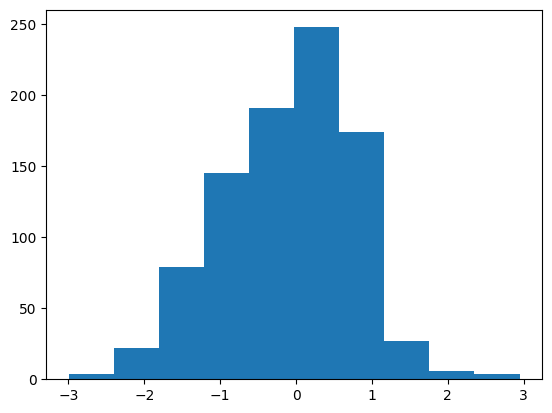

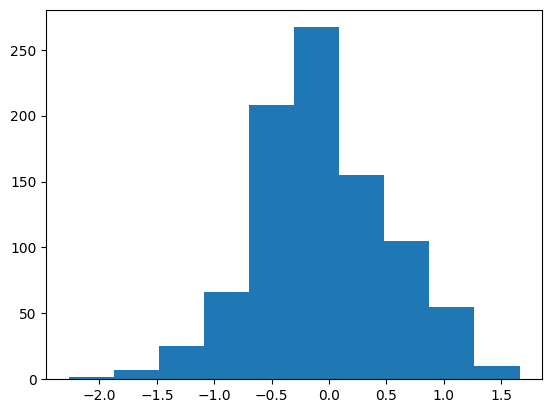

In [1023]:
plt.hist(peak_within_bounds[:,1])
plt.show()
plt.hist(-peak_within_bounds[:,0])
plt.show()

In [1021]:
# percentage of samples where true peak is within one/two/three standard deviations

# coverage of credibility intervals

print("Percentage of phantoms such that true peak location is within one standard deviation from estimated location ",
      np.where( (np.abs(peak_within_bounds[:,0])<1) & (np.abs(peak_within_bounds[:,1])<1) )[0].size / peak_within_bounds.shape[0])
print("Percentage of phantoms such that true peak location is within two standard deviations from estimated location ",
      np.where( (np.abs(peak_within_bounds[:,0])<2) & (np.abs(peak_within_bounds[:,1])<2) )[0].size / peak_within_bounds.shape[0])
print("Percentage of phantoms such that true peak location is within three standard deviations from estimated location ",
      np.where( (np.abs(peak_within_bounds[:,0])<3) & (np.abs(peak_within_bounds[:,1])<3) )[0].size / peak_within_bounds.shape[0])

Percentage of phantoms such that true peak location is within one standard deviation from estimated location  0.6966666666666667
Percentage of phantoms such that true peak location is within two standard deviations from estimated location  0.98
Percentage of phantoms such that true peak location is within three standard deviations from estimated location  1.0


### Pixel value bound study

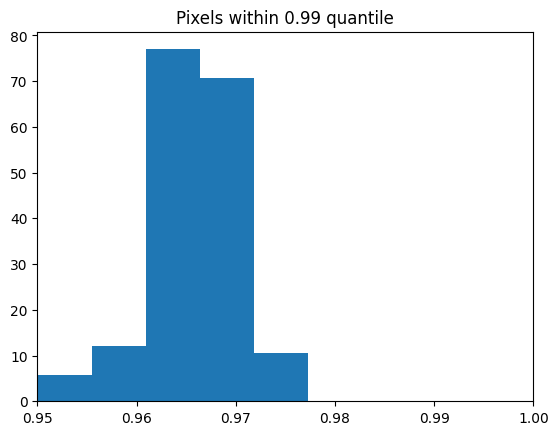

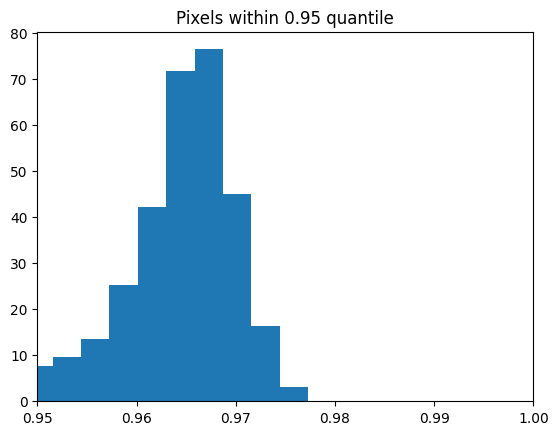

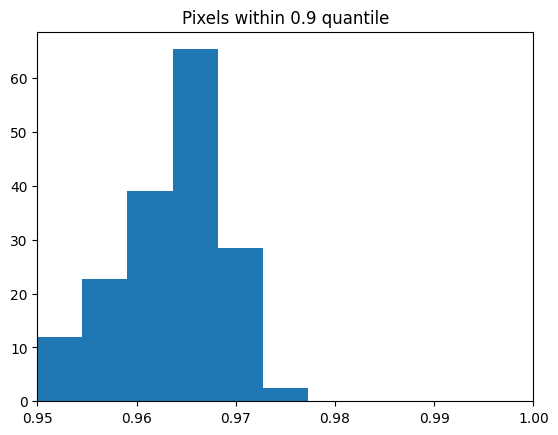

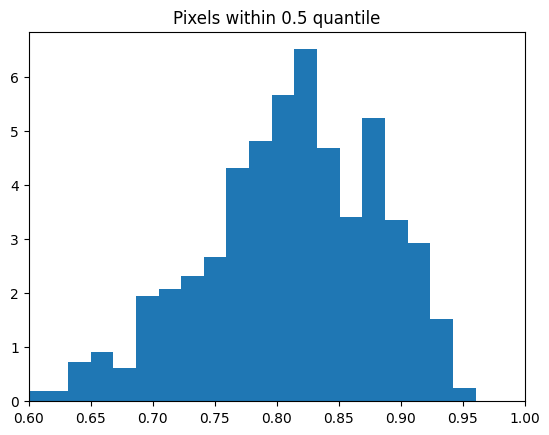

In [186]:
plt.hist(pixels_within_quantiles[:,0], density=True, bins=10)
plt.xlim([0.95,1])
plt.title("Pixels within 0.99 quantile")
plt.show()

plt.hist(pixels_within_quantiles[:,1], density=True,bins=30)
plt.xlim([0.95,1])
plt.title("Pixels within 0.95 quantile")
plt.show()

plt.hist(pixels_within_quantiles[:,2], density=True,bins=30)
plt.xlim([0.95,1])
plt.title("Pixels within 0.9 quantile")
plt.show()

plt.hist(pixels_within_quantiles[:,3], density=True,bins=30)
plt.xlim([0.6,1])
plt.title("Pixels within 0.5 quantile")
plt.show()

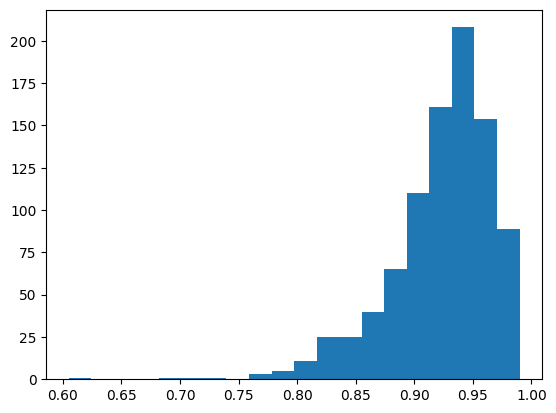

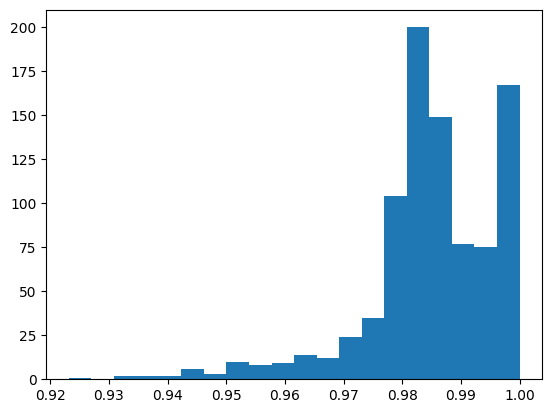

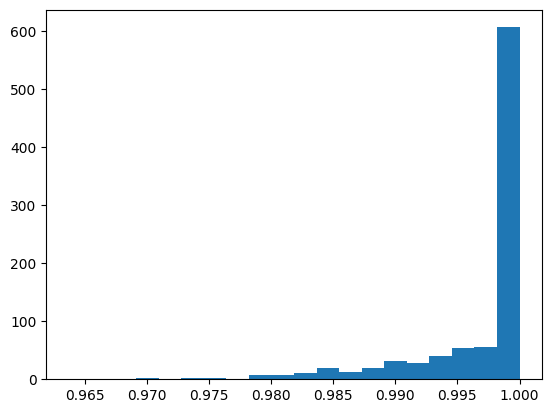

In [188]:
plt.hist(pixels_within_one_std, bins=20)
plt.show()
plt.hist(pixels_within_two_stds, bins=20)
plt.show()
plt.hist(pixels_within_three_stds, bins=20)
plt.show()

In [189]:
print("Average (across phantoms) percentage of pixels falling within one standard deviation from the mean ",
      np.mean(pixels_within_one_std), " +- ", np.std(pixels_within_one_std))
print("Average (across phantoms) percentage of pixels falling within two standard deviations from the mean ",
      np.mean(pixels_within_two_stds), " +- ", np.std(pixels_within_two_stds))
print("Average (across phantoms) percentage of pixels falling within three standard deviations from the mean ",
      np.mean(pixels_within_three_stds), " +- ", np.std(pixels_within_three_stds))


Average (across phantoms) percentage of pixels falling within one standard deviation from the mean  0.9230011285174102  +-  0.04406538355448803
Average (across phantoms) percentage of pixels falling within two standard deviations from the mean  0.9849623588943949  +-  0.011627069337321485
Average (across phantoms) percentage of pixels falling within three standard deviations from the mean  0.9970362525348292  +-  0.005394878651102485


In [191]:
for j in range(4):
    print("Average (across phantoms) percentage of pixels falling within {:.0f} % credibility interval ".format(100*(quantile_marks[-(j+1)]-quantile_marks[j])),
          100*np.mean(pixels_within_quantiles[:,j]), "%")

Average (across phantoms) percentage of pixels falling within 99 % credibility interval  96.48809966531203 %
Average (across phantoms) percentage of pixels falling within 95 % credibility interval  96.13503420437026 %
Average (across phantoms) percentage of pixels falling within 90 % credibility interval  95.65672455381777 %
Average (across phantoms) percentage of pixels falling within 50 % credibility interval  80.89016510835204 %


Study width of twice the standard deviation versus quantile values, studying average across phantoms

In [192]:
coeff_quantiles_to_twice_std = np.zeros((900,4))

quantile_marks = [0.005, 0.025, 0.05, 0.25, 0.5, 0.75, 0.95, 0.975, 0.995]

for idx in range(900):
    recon_shape = (120, 40)

    anis_data_idx = np.load('sigma005/anis_data_'+str(idx)+'.npy', allow_pickle=True).item()
    uq_data_idx = np.load('sigma005/uq_data_'+str(idx)+'.npy', allow_pickle=True).item()

    ground_truth = sxr_samples[idx, :, :].squeeze()
    psi = psis[idx, :, :]


    f,g = fct_def.define_loglikelihood_and_logprior(ground_truth, psi, sigma_err=uq_data_idx["sigma_err"],
                                                    reg_fct_type="anisotropic", alpha=uq_data_idx["alpha"], seed=idx)

    mask_core = tomo_helps.define_core_mask(psi=psi, dim_shape=recon_shape, trim_values_x=trim_val[idx,:])
    reg_param = uq_data_idx["reg_param"]

    # compute pixels withing quantile bounds stats
    ground_truth_downsampled = skimt.resize(ground_truth, uq_data_idx["im_MAP"].shape, anti_aliasing=False, mode='edge') * mask_core
    for j in range(4):
        tmp = (uq_data_idx["empirical_quantiles"][-(j+1),:,:][mask_core] - uq_data_idx["empirical_quantiles"][j,:,:][mask_core]) / (2*np.sqrt(uq_data_idx["var"][mask_core]))
        coeff_quantiles_to_twice_std[idx, j] = np.mean(tmp)

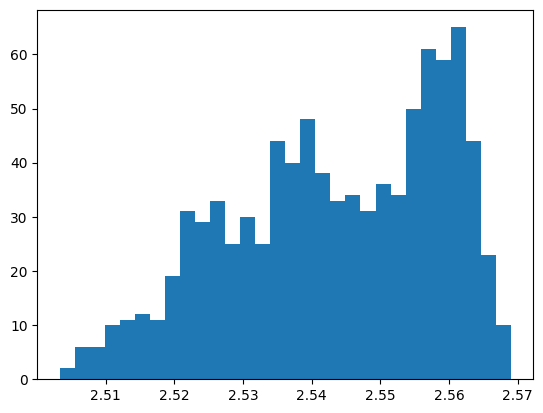

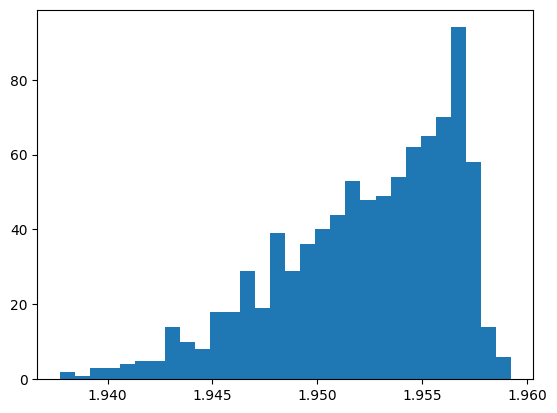

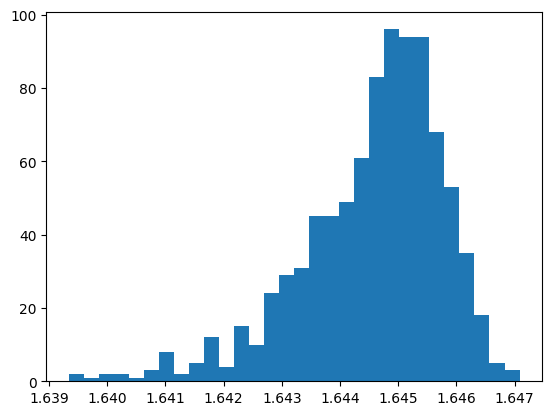

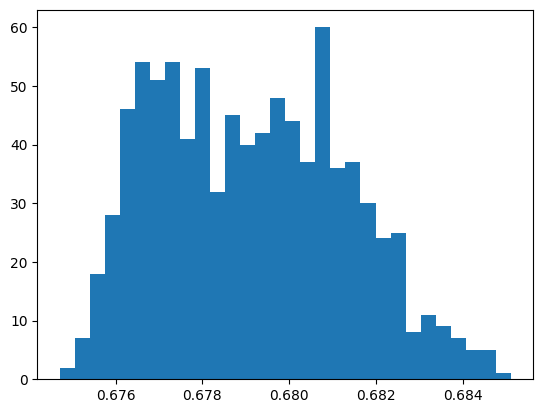

In [193]:
plt.hist(coeff_quantiles_to_twice_std[:,0], bins=30)
plt.title("")
plt.show()
plt.hist(coeff_quantiles_to_twice_std[:,1], bins=30)
plt.show()
plt.hist(coeff_quantiles_to_twice_std[:,2], bins=30)
plt.show()
plt.hist(coeff_quantiles_to_twice_std[:,3], bins=30)
plt.show()

Study if quantiles are symmetric around the mean

In [93]:
idx=0
anis_data_idx = np.load('sigma005/anis_data_'+str(idx)+'.npy', allow_pickle=True).item()
uq_data_idx = np.load('sigma005/uq_data_'+str(idx)+'.npy', allow_pickle=True).item()

ground_truth = sxr_samples[idx, :, :].squeeze()
psi = psis[idx, :, :]


f,g = fct_def.define_loglikelihood_and_logprior(ground_truth, psi, sigma_err=uq_data_idx["sigma_err"],
                                                reg_fct_type="anisotropic", alpha=uq_data_idx["alpha"], seed=idx)

mask_core = tomo_helps.define_core_mask(psi=psi, dim_shape=recon_shape, trim_values_x=trim_val[idx,:])
reg_param = uq_data_idx["reg_param"]

In [112]:
pixels_within_two_stds[idx]

np.float64(1.0)

In [110]:
pixels_within_quantiles[idx,3]

np.float64(0.8793634496919918)

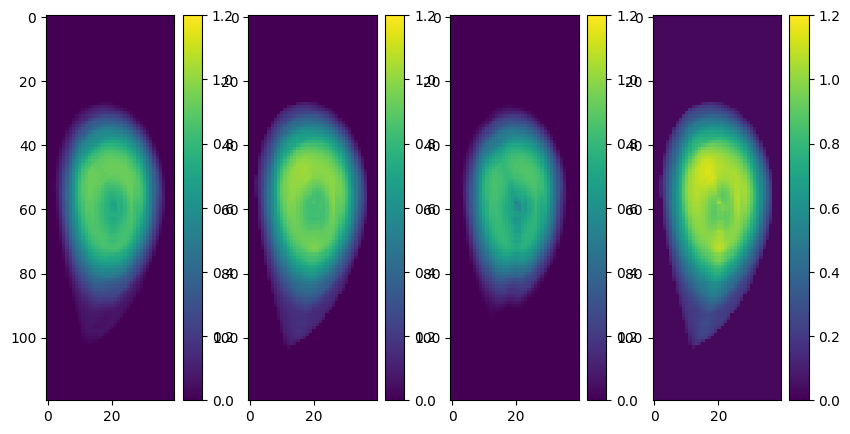

In [108]:
fig,ax=plt.subplots(1,4, figsize=(10,5))
r=ax[0].imshow(uq_data_idx["empirical_quantiles"][3,:,:], vmin=0, vmax=1.2)
plt.colorbar(r,ax=ax[0])
r=ax[1].imshow(uq_data_idx["empirical_quantiles"][-4,:,:], vmin=0, vmax=1.2)
plt.colorbar(r,ax=ax[1])
r=ax[2].imshow(uq_data_idx["mean"]-2*np.sqrt(uq_data_idx["var"]), vmin=0, vmax=1.2)
plt.colorbar(r,ax=ax[2])
r=ax[3].imshow(uq_data_idx["mean"]+2*np.sqrt(uq_data_idx["var"]), vmin=0, vmax=1.2)
plt.colorbar(r,ax=ax[3])

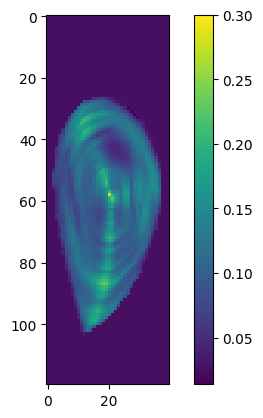

In [116]:
ground_truth_downsampled = skimt.resize(ground_truth, uq_data_idx["im_MAP"].shape, anti_aliasing=False, mode='edge') * mask_core
plt.imshow(uq_data_idx["mean"]+2*np.sqrt(uq_data_idx["var"])-ground_truth_downsampled, vmin=None, vmax=0.3)
plt.colorbar()

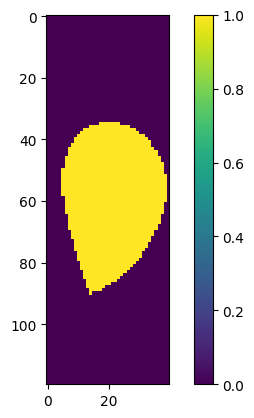

In [184]:
idx=49
anis_data_idx = np.load('sigma005/anis_data_'+str(idx)+'.npy', allow_pickle=True).item()
uq_data_idx = np.load('sigma005/uq_data_'+str(idx)+'.npy', allow_pickle=True).item()

ground_truth = sxr_samples[idx, :, :].squeeze()
psi = psis[idx, :, :]


f,g = fct_def.define_loglikelihood_and_logprior(ground_truth, psi, sigma_err=uq_data_idx["sigma_err"],
                                                reg_fct_type="anisotropic", alpha=uq_data_idx["alpha"], seed=idx)

mask_core = tomo_helps.define_core_mask(psi=psi, dim_shape=recon_shape, trim_values_x=trim_val[idx,:])
reg_param = uq_data_idx["reg_param"]

ff= skimt.resize(ground_truth, uq_data_idx["im_MAP"].shape, anti_aliasing=False, mode='edge')
ff[ff>1e-3]=1
plt.imshow(ff)
plt.colorbar()

In [199]:
sigma_err = 1e-2
sigma_err_vec = [1e-2, 5e-2]
sigma_err_arr=np.array(sigma_err)

In [196]:
type(sigma_err)

float

In [198]:
type(sigma_err_vec)

list

In [206]:
type(sigma_err_arr)

numpy.ndarray

In [207]:
if isinstance(sigma_err_arr, np.ndarray):
    print("f")

f


In [208]:
if isinstance(sigma_err_vec, np.ndarray):
    print("f")

In [212]:
if isinstance(sigma_err_arr, float):
    print("f")

In [213]:
(isinstance(sigma_err, np.ndarray) and sigma_err.size == 1)

False

In [215]:
(isinstance(sigma_err_arr, np.ndarray) and sigma_err_arr.size == 1)

True

In [214]:
(isinstance(sigma_err_vec, np.ndarray) and sigma_err_vec.size == 1)

False

In [216]:
from scipy.sparse import csr_matrix

In [217]:
A=f.forward_model_linop.mat

In [231]:
A.shape

(100, 4800)

In [221]:
A.nnz

8317

In [232]:
ss=np.random.rand(100)
Anew = A / np.hstack([ss.reshape(-1,1)]*A.shape[1])

In [233]:
np.hstack([ss.reshape(-1,1)]*A.shape[1]).shape

(100, 4800)

In [234]:
Anew.shape

(100, 4800)

In [235]:
type(Anew)

scipy.sparse._coo.coo_matrix

In [236]:
Anew.nnz

8317

In [276]:
uq_data_idx["sigma_err"]

array(0.00749271)

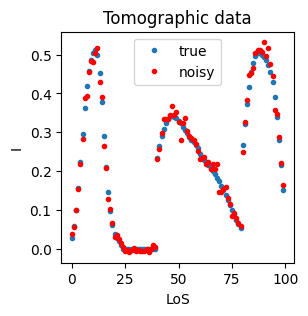

In [439]:
idx=1
anis_data_idx = np.load('sigma005/anis_data_'+str(idx)+'.npy', allow_pickle=True).item()
uq_data_idx = np.load('sigma005/uq_data_'+str(idx)+'.npy', allow_pickle=True).item()

ground_truth = sxr_samples[idx, :, :].squeeze()
psi = psis[idx, :, :]

sigma_err = [7e-3, 5e-2]

f,g = fct_def.define_loglikelihood_and_logprior(ground_truth, psi, sigma_err=sigma_err,
                                                reg_fct_type="anisotropic", alpha=uq_data_idx["alpha"], seed=idx, plot=True)

mask_core = tomo_helps.define_core_mask(psi=psi, dim_shape=recon_shape, trim_values_x=trim_val[idx,:])
reg_param = uq_data_idx["reg_param"]

In [374]:
sigma_err = [7e-3, 5e-2]
#sigma_err = 7e-3
f = fct_def._DataFidelityFunctional(dim_shape=(1,120,40), noisy_tomo_data=f2.noisy_tomo_data, sigma_err=sigma_err, grid="coarse")

/home/dhamm/miniconda3/envs/bayes-plasma-tomo/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:483: UserWarning: Exited at iteration 20 with accuracies 
[0.0015009]
not reaching the requested tolerance 1.4901161193847656e-06.
Use iteration 21 instead with accuracy 
0.001500903009761322.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/home/dhamm/miniconda3/envs/bayes-plasma-tomo/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:483: UserWarning: Exited postprocessing with accuracies 
[0.0015009]
not reaching the requested tolerance 1.4901161193847656e-06.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


In [434]:
geometry_matrix = sp.load_npz("../../tomo_fusion/forward_model/geometry_matrices/sparse_geometry_matrix_sxr.npz")

In [441]:
normalized_geometry_matrix = geometry_matrix / np.hstack([sigma_err_vec.reshape(-1,1)]*geometry_matrix.shape[1])

In [456]:
import scipy
norm_matrix = scipy.linalg.norm(normalized_geometry_matrix.toarray(), 2)

In [458]:
import warnings
with warnings.catch_warnings():
    #warnings.simplefilter("ignore")
    norm_matrix_sparse = sp.linalg.norm(normalized_geometry_matrix, 2)

/home/dhamm/miniconda3/envs/bayes-plasma-tomo/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:483: UserWarning: Exited at iteration 20 with accuracies 
[0.00017754]
not reaching the requested tolerance 1.4901161193847656e-06.
Use iteration 21 instead with accuracy 
0.00017753512795866554.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/home/dhamm/miniconda3/envs/bayes-plasma-tomo/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:483: UserWarning: Exited postprocessing with accuracies 
[0.00017754]
not reaching the requested tolerance 1.4901161193847656e-06.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


In [457]:
print(norm_matrix,norm_matrix_sparse)

13.899341718483711 13.899341718483516


In [463]:
se = np.load('../dataset_generation/hyperparam_tuning/reg_param_tuning_fine_anisotropic_newbounds_sigma005005/sigma_err.npy')

In [466]:
isinstance(se,np.ndarray)

True

In [467]:
se

array([0.00749271, 0.05      ])

In [357]:
from scipy.stats import pearsonr
pearsonr(np.abs(f.noisy_tomo_data-f.tomo_data),f.tomo_data)

PearsonRResult(statistic=np.float64(0.5449113147334893), pvalue=np.float64(4.5933210159760265e-09))

In [358]:
ground_truth_downsampled = skimt.resize(ground_truth, uq_data_idx["im_MAP"].shape, anti_aliasing=False, mode='edge')

In [440]:
sigma_err_vec = sigma_err[0] + sigma_err[1] * f.noisy_tomo_data
sigma_err_vec_true = sigma_err[0] + sigma_err[1] * f.tomo_data 

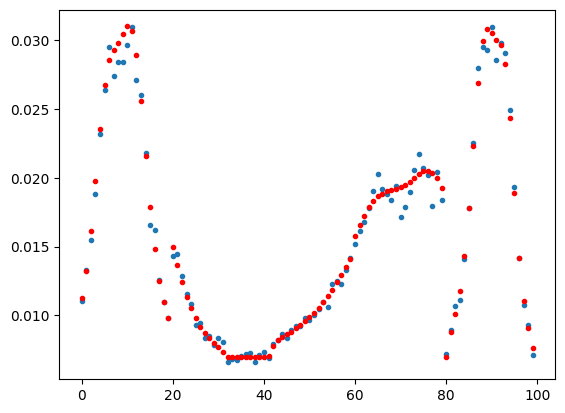

In [368]:
plt.plot(sigma_err_vec, '.')
plt.plot(sigma_err_vec_true, 'r.')

In [364]:
vec = ground_truth_downsampled
fv=f.forward_model_linop(vec)
fv2=f2.forward_model_linop(vec)

In [365]:
fv2.shape

(100,)

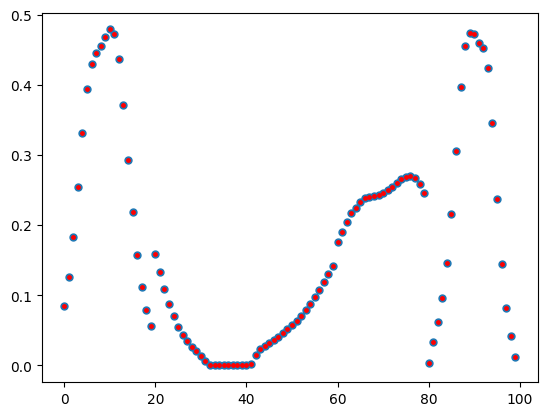

In [369]:
#plt.plot(fv*f.noisy_tomo_data/sigma_err_vec,'.',markersize=10)
plt.plot(fv*sigma_err_vec,'.',markersize=10)
plt.plot(fv2,'r.', markersize=5)

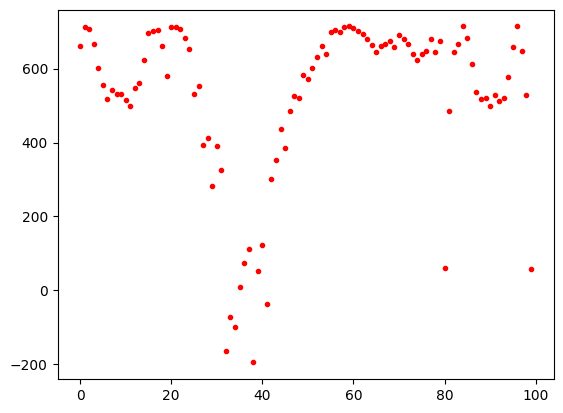

In [340]:
plt.plot(f.noisy_tomo_data / sigma_err_vec**2 , '.r')

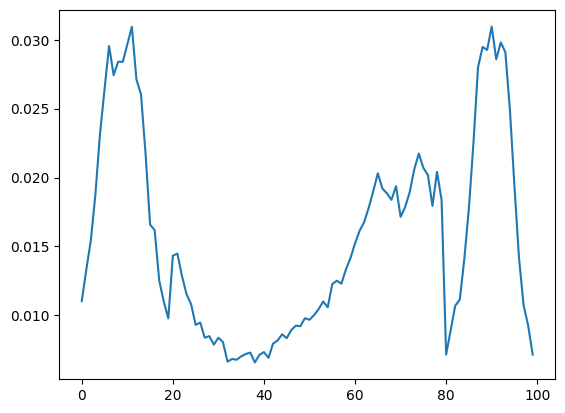

In [331]:
plt.plot(sigma_err_vec)

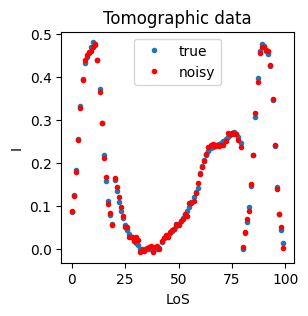

In [361]:
anis_data_idx = np.load('sigma005/anis_data_'+str(idx)+'.npy', allow_pickle=True).item()
uq_data_idx = np.load('sigma005/uq_data_'+str(idx)+'.npy', allow_pickle=True).item()

ground_truth = sxr_samples[idx, :, :].squeeze()
psi = psis[idx, :, :]

sigma_err = 7e-3

f2,g = fct_def.define_loglikelihood_and_logprior(ground_truth, psi, sigma_err=sigma_err,
                                                reg_fct_type="anisotropic", alpha=uq_data_idx["alpha"], seed=idx, plot=True)

mask_core = tomo_helps.define_core_mask(psi=psi, dim_shape=recon_shape, trim_values_x=trim_val[idx,:])
reg_param = uq_data_idx["reg_param"]

In [297]:
from scipy.stats import pearsonr
pearsonr(np.abs(f2.noisy_tomo_data-f2.tomo_data),f2.tomo_data)

PearsonRResult(statistic=np.float64(-0.03631188213953986), pvalue=np.float64(0.7198405947832388))

In [253]:
fp=f(np.random.rand(120,40))

In [263]:
fp=f.grad(np.random.rand(120,40))

In [298]:
sigma_level = [0.05, 0.05]

In [299]:
if isinstance(sigma_level, list) and len(sigma_level) == 2:
    print("ciumbia")

ciumbia


In [301]:
if isinstance(sigma_level, float):
    print("fuck")

In [305]:
f.forward_model_linop

_ExplicitLinOpSparseMatrix(dim=(1, 120, 40), codim=(100,))

In [307]:
f.noisy_tomo_data.shape

(100,)

In [526]:
7e-3*2

0.014

In [527]:
1.4e-2

0.014

### Understand why anis param tuning is so slow

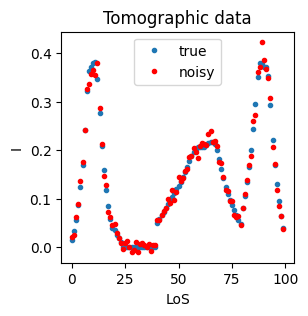

In [659]:
idx=910

ground_truth = sxr_samples[idx, :, :].squeeze()
psi = psis[idx, :, :]

sigma_err = [7e-3, 5e-2]
#sigma_err = 1.4e-2
#sigma_err = 7e-3

f,g = fct_def.define_loglikelihood_and_logprior(ground_truth, psi, sigma_err=sigma_err,
                                                reg_fct_type="anisotropic", alpha=alphas[idx], seed=idx, plot=True)

mask_core = tomo_helps.define_core_mask(psi=psi, dim_shape=recon_shape, trim_values_x=trim_val[idx,:])
reg_param = uq_data_idx["reg_param"]

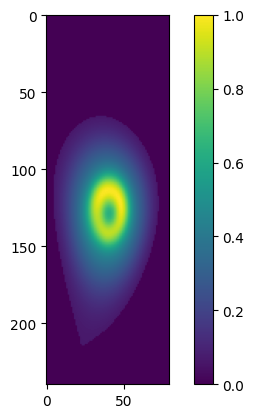

In [660]:
plt.imshow(ground_truth)
plt.colorbar()

In [661]:
f.sigma_err

[0.007, 0.05]

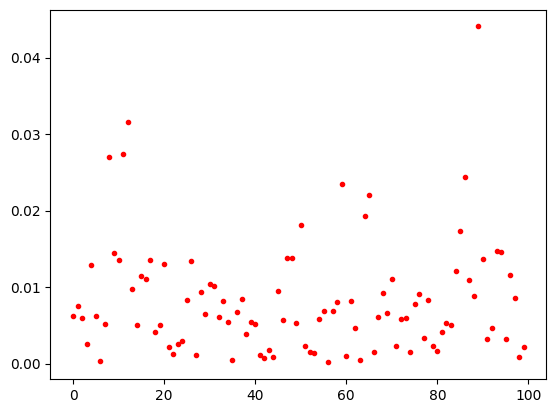

In [662]:
plt.plot(np.abs(f.noisy_tomo_data-f.tomo_data), 'r.')

In [663]:
pearsonr(np.abs(f.noisy_tomo_data-f.tomo_data), f.tomo_data)

PearsonRResult(statistic=np.float64(0.4789556901031543), pvalue=np.float64(4.634855834519697e-07))

In [664]:
reg_param = np.load('../dataset_generation/hyperparam_tuning/reg_param_tuning_fine_anisotropic_newbounds_sigma005005/reg_param_median.npy')
#reg_param = 0.1

In [665]:
reg_param

array(0.03162278)

In [666]:
reg_param_data_idx = hyper_tune.reg_param_tuning(f, g, tuning_techniques=["GT"], ground_truth=ground_truth,
                                                         with_pos_constraint=True, clipping_mask=mask_core,
                                                         cv_strategy="random",
                                                         reg_params=np.logspace(-4, 1, 21), plot=False)

Tuning regularization parameter: comparison to ground truth (`GT`)



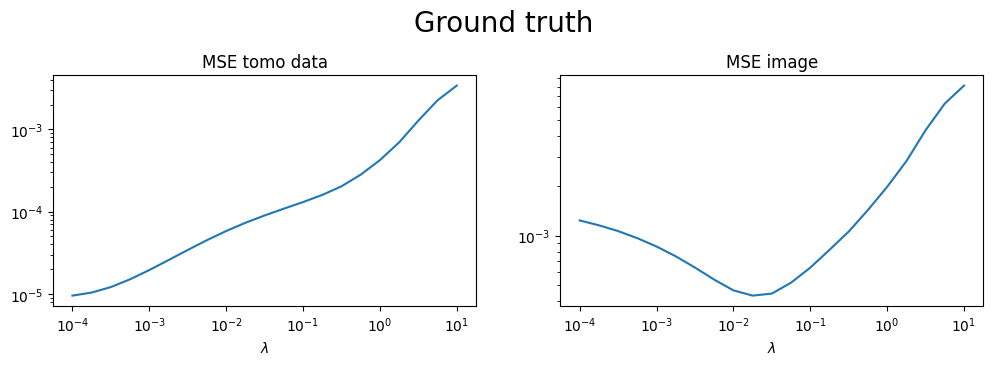

In [667]:
tomo_plots.plot_hyperparam_tuning_data(reg_param_data_idx)

In [654]:
anis_param_data = hyper_tune.anis_param_tuning(f, g, reg_param,
                                                       tuning_techniques=["CV_full"],
                                                       ground_truth=ground_truth,
                                                       with_pos_constraint=True, clipping_mask=mask_core,
                                                       cv_strategy=["random"],
                                                       anis_params=np.logspace(-4, 0, 13), plot=False)

Tuning regularization parameter: 5-fold cross validation (`CV_full`)



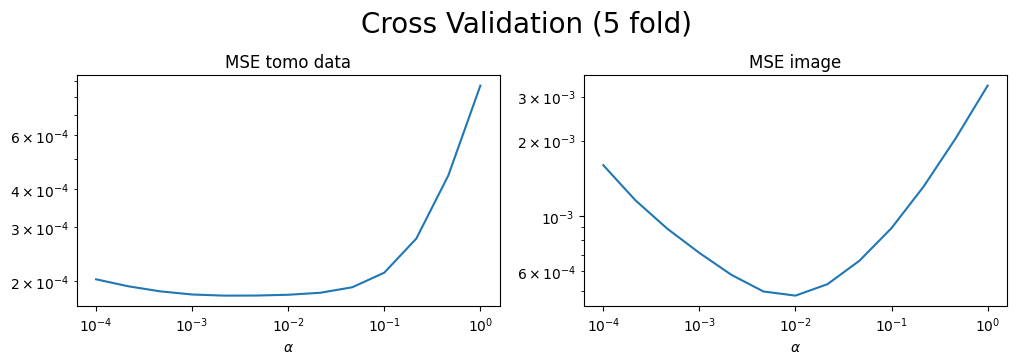

In [655]:
tomo_plots.plot_hyperparam_tuning_data(anis_param_data, param="anis_param")

In [674]:
np.argmin(anis_param_data["CV_full_random"][1,:])

np.int64(4)

In [649]:
anis_param_data["CV_full_random"][0,:]

array([1.00000000e-04, 2.15443469e-04, 4.64158883e-04, 1.00000000e-03,
       2.15443469e-03, 4.64158883e-03, 1.00000000e-02, 2.15443469e-02,
       4.64158883e-02, 1.00000000e-01, 2.15443469e-01, 4.64158883e-01,
       1.00000000e+00])

In [657]:
f_cv = fct_def.define_loglikelihood_cv(f, cv_type="CV_full", cv_strategy="random")
im_MAP = bcomp.compute_MAP(f_cv[0], hyper_tune._redefine_anis_param_logprior(g,2e-3), reg_param, with_pos_constraint=True, clipping_mask=mask_core, show_progress=False)
t = (f(im_MAP) - f_cv[0](im_MAP)) * (2 * f.sigma_err ** 2) / f_cv[0].cv_test_idx.size
                        

/home/dhamm/miniconda3/envs/bayes-plasma-tomo/lib/python3.12/site-packages/pyxu_diffops/operator/diffusion/_diffusion_coeff.py:147: UserWarning: DiffusionCoefficient had already been frozen. Overwriting previous frozen state.
  warnings.warn("DiffusionCoefficient had already been frozen. Overwriting previous frozen state.")


TypeError: unsupported operand type(s) for ** or pow(): 'list' and 'int'

In [672]:
f.forward_model_linop

_ExplicitLinOpSparseMatrix(dim=(1, 120, 40), codim=(100,))

In [673]:
reg_param

array(0.03162278)

In [713]:
im_MAP = bcomp.compute_MAP(f, hyper_tune._redefine_anis_param_logprior(g,4.6e-2), reg_param, with_pos_constraint=True, clipping_mask=mask_core, show_progress=False)

/home/dhamm/miniconda3/envs/bayes-plasma-tomo/lib/python3.12/site-packages/pyxu_diffops/operator/diffusion/_diffusion_coeff.py:147: UserWarning: DiffusionCoefficient had already been frozen. Overwriting previous frozen state.
  warnings.warn("DiffusionCoefficient had already been frozen. Overwriting previous frozen state.")


In [714]:
print(np.mean(
    (im_MAP-skimt.resize(ground_truth, uq_data_idx["im_MAP"].shape, anti_aliasing=False, mode='edge'))**2
))

0.0005711276058460575


In [711]:
print(np.mean(
    (im_MAP-skimt.resize(ground_truth, uq_data_idx["im_MAP"].shape, anti_aliasing=False, mode='edge'))**2
))

0.00041685692677613555


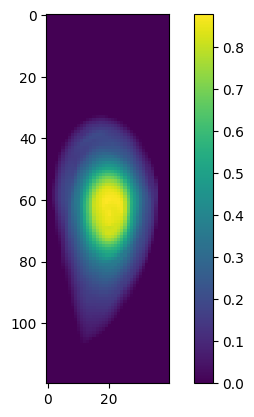

In [715]:
plt.imshow(im_MAP)
plt.colorbar()

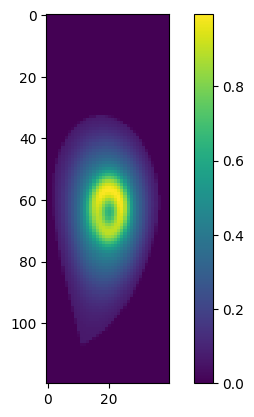

In [697]:
plt.imshow(skimt.resize(ground_truth, uq_data_idx["im_MAP"].shape, anti_aliasing=False, mode='edge'))
plt.colorbar()

In [625]:
len(f_cv)

5

In [626]:
f_cv[0].cv_test_idx.size

20

In [627]:
print(f(im_MAP),f_cv[0](im_MAP))

[44.99985448] [35.83096762]


In [628]:
print(t)

[0.00017971]


In [629]:
np.sort(f_cv[0].cv_idx)

array([ 0,  1,  4,  5,  7,  8,  9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20,
       23, 24, 25, 26, 27, 29, 30, 31, 32, 33, 35, 36, 37, 38, 39, 40, 41,
       42, 43, 44, 46, 47, 48, 49, 51, 52, 53, 55, 56, 57, 59, 61, 62, 63,
       64, 65, 66, 67, 70, 71, 74, 75, 76, 77, 78, 79, 80, 81, 82, 84, 85,
       86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 98, 99])

In [630]:
np.sort(f_cv[0].cv_test_idx)

array([ 2,  3,  6, 13, 21, 22, 28, 34, 45, 50, 54, 58, 60, 68, 69, 72, 73,
       83, 96, 97])

In [612]:
idxs = np.arange(0, 100)
np.random.seed(0)
np.random.shuffle(idxs)
i=0
print(np.sort(idxs))
print(idxs)
print(idxs[i * 20: (i + 1) * 20])
cv_idx = np.delete(idxs, idxs[i * 20: (i + 1) * 20])

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99]
[26 86  2 55 75 93 16 73 54 95 53 92 78 13  7 30 22 24 33  8 43 62  3 71
 45 48  6 99 82 76 60 80 90 68 51 27 18 56 63 74  1 61 42 41  4 15 17 40
 38  5 91 59  0 34 28 50 11 35 23 52 10 31 66 57 79 85 32 84 14 89 19 29
 49 97 98 69 20 94 72 77 25 37 81 46 39 65 58 12 88 70 87 36 21 83  9 96
 67 64 47 44]
[26 86  2 55 75 93 16 73 54 95 53 92 78 13  7 30 22 24 33  8]


In [607]:
np.sort(cv_idx)

array([ 0,  1,  4,  5,  7,  8,  9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20,
       23, 24, 25, 26, 27, 29, 30, 31, 32, 33, 35, 36, 37, 38, 39, 40, 41,
       42, 43, 44, 46, 47, 48, 49, 51, 52, 53, 55, 56, 57, 59, 61, 62, 63,
       64, 65, 66, 67, 70, 71, 74, 75, 76, 77, 78, 79, 80, 81, 82, 84, 85,
       86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 98, 99])

In [613]:
print(cv_idx.shape)

(80,)


In [614]:
np.sort(idxs[idxs[i * 20: (i + 1) * 20]])

array([ 2,  3,  6, 13, 21, 22, 28, 34, 45, 50, 54, 58, 60, 68, 69, 72, 73,
       83, 96, 97])

In [510]:
anis_param_data

{'CV_full_random': array([[1.00000000e-04, 2.15443469e-04, 4.64158883e-04, 1.00000000e-03,
         2.15443469e-03, 4.64158883e-03, 1.00000000e-02, 2.15443469e-02,
         4.64158883e-02, 1.00000000e-01, 2.15443469e-01, 4.64158883e-01,
         1.00000000e+00],
        [5.34031471e-05, 5.32810277e-05, 5.36509365e-05, 5.42238638e-05,
         5.46529322e-05, 5.51437837e-05, 5.60654639e-05, 5.80787055e-05,
         6.18378048e-05, 6.77201839e-05, 7.69544199e-05, 9.69050165e-05,
         1.56240603e-04],
        [1.60001577e-03, 1.24966327e-03, 9.53406228e-04, 7.25910603e-04,
         5.67036328e-04, 4.45672400e-04, 3.52917606e-04, 2.89067617e-04,
         2.66473866e-04, 2.86493929e-04, 3.31781876e-04, 3.95483821e-04,
         5.26780622e-04],
        [8.68495949e-01, 8.78417331e-01, 8.89515895e-01, 9.00138793e-01,
         9.09056501e-01, 9.18852869e-01, 9.30331526e-01, 9.42790531e-01,
         9.52195815e-01, 9.55321342e-01, 9.53400906e-01, 9.49200900e-01,
         9.43041894e-01]])}